In [1]:
import cv2
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

In [2]:
def removeLines(img):
    image= cv2.imread(img,0) # reads image as grayscale

    # use gaussian filter to smooth the image
    binary= cv2.GaussianBlur(image,(3,3),10)


    # use otsu thresholding for accurate conversion to binary image
    thresh = threshold_otsu(image)
    binary = image > thresh
    # convert binary image to uint8 with 255 as white and 0 as black
    binary = binary.astype(np.uint8)*255
    binary_inv = cv2.bitwise_not(binary)
    # Identifying the horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    detected_lines = cv2.morphologyEx(binary_inv, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=1)

    # dialate the detected lines
    detected_lines = cv2.dilate(detected_lines, np.ones((3,2)), iterations=1)

    # GaussianBlur the detected lines
    detected_lines= cv2.GaussianBlur(detected_lines,(3,3),10)
    detected_lines_inv = cv2.bitwise_not(detected_lines)

    plt.imshow(detected_lines, cmap='gray')
    plt.title('Detected Lines')
    plt.axis('off')
    plt.show()

    newimg= cv2.inpaint(image,detected_lines,2,cv2.INPAINT_TELEA)
    plt.imshow(newimg, cmap='gray',)
    plt.title('Inpainted Image')
    plt.axis('off')
    plt.show()
    
    # Save the inpainted image
    output1_path = 'output1.jpg'
    cv2.imwrite(output1_path, newimg)
    print("Inpainted image saved as:", output1_path)
    
    return newimg

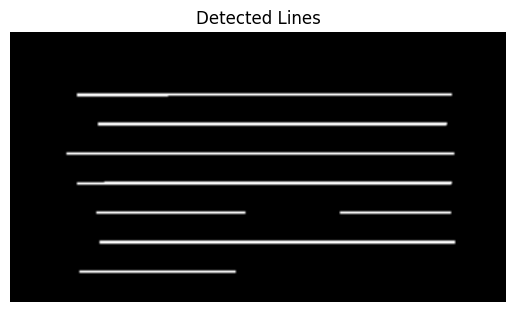

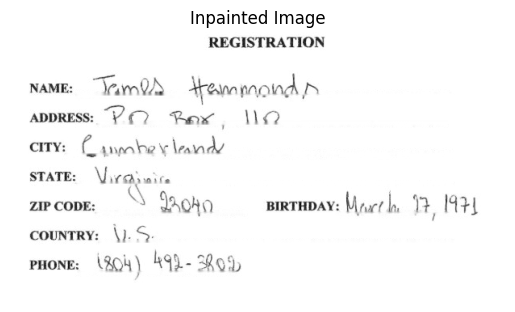

Inpainted image saved as: output1.jpg


In [95]:
preprocessed=removeLines('document.jpg')


In [114]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def text_segmentation(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    # Initialize list to store word bounding boxes
    word_boxes = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label] 
        if area < 1: 
            continue
        word_boxes.append((x, y, w, h))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Text with Bounding Boxes')
    plt.axis('off')
    
    # Save the displayed image
    output2_path = 'output2.jpg'
    plt.savefig(output2_path)
    print("Segmented image with bounding boxes saved as:", output2_path)
    
    # Show the displayed image
    plt.show()
    
    # Save the segmented image with bounding boxes
    cv2.imwrite('output2_opencv.jpg', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    print("Segmented image with bounding boxes saved as: output2_opencv.jpg")
    
    return word_boxes


Segmented image with bounding boxes saved as: output2.jpg


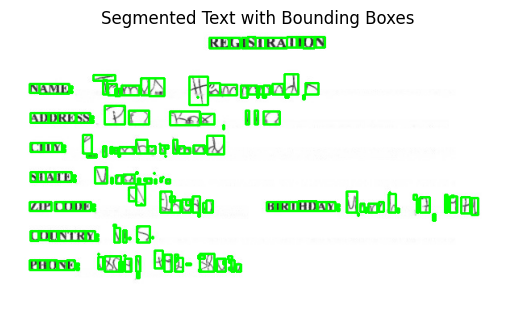

Segmented image with bounding boxes saved as: output2_opencv.jpg


In [161]:
word_boxes=text_segmentation("output1.jpg");

In [157]:
from sklearn.cluster import KMeans
import numpy as np

# Sample list of boxes in the format (x,y,w,h)
boxes = word_boxes

# Convert box coordinates to numpy array
box_coords = np.array([[x, y] for x, y, _, _ in boxes])

# Perform KMeans clustering for x-coordinates
kmeans_x = KMeans(n_clusters=3, random_state=0).fit(box_coords[:, 0].reshape(-1, 1))

# Get the labels assigned to each box for x-coordinates
x_labels = kmeans_x.labels_

# Group boxes according to their x-coordinate labels
grouped_boxes = {}
for label, box in zip(x_labels, boxes):
    if label not in grouped_boxes:
        grouped_boxes[label] = []
    grouped_boxes[label].append(box)

# For each group of boxes, perform clustering for y-coordinates
final_grouped_boxes = {}
for key, group in grouped_boxes.items():
    box_coords_y = np.array([[x, y] for x, y, _, _ in group])
    kmeans_y = KMeans(n_clusters=2, random_state=0).fit(box_coords_y[:, 1].reshape(-1, 1))
    y_labels = kmeans_y.labels_
    for sub_label, sub_box in zip(y_labels, group):
        final_grouped_boxes.setdefault((key, sub_label), []).append(sub_box)

print(final_grouped_boxes)


{(0, 1): [(247, 8, 24, 13), (272, 8, 13, 13), (294, 7, 10, 14), (287, 8, 6, 13), (304, 8, 12, 13), (317, 8, 26, 13), (172, 58, 19, 22), (222, 56, 23, 35), (245, 64, 15, 15), (260, 66, 21, 13), (286, 67, 8, 15), (295, 67, 11, 11), (325, 65, 14, 13), (314, 67, 8, 11), (308, 68, 5, 10), (232, 81, 1, 1), (306, 79, 2, 3), (313, 79, 4, 3), (198, 99, 37, 17), (236, 102, 17, 13), (292, 98, 4, 17), (303, 98, 4, 17), (314, 99, 20, 16), (264, 116, 1, 5), (244, 129, 21, 23), (202, 134, 5, 17), (185, 139, 1, 1), (171, 142, 9, 9), (175, 142, 1, 1), (186, 141, 6, 10), (191, 141, 5, 4), (209, 142, 7, 9), (227, 141, 14, 10), (216, 144, 7, 7), (192, 154, 1, 1)], (0, 0): [(178, 175, 1, 1), (189, 180, 1, 1), (169, 182, 6, 6), (186, 181, 2, 5), (179, 183, 2, 5), (193, 183, 5, 5), (186, 198, 14, 26), (198, 204, 6, 7), (226, 204, 9, 20), (200, 209, 11, 15), (213, 208, 11, 16), (218, 208, 5, 7), (243, 209, 8, 15), (239, 212, 4, 12), (318, 211, 10, 11), (329, 211, 5, 11), (335, 211, 11, 11), (233, 225, 2, 4), 

In [116]:
def findAverageWidth(word_boxes):
    # Initialize list to store the width of each word
    word_widths = []
    
    # Iterate over each word bounding box
    for box in word_boxes:
        x, y, w, h = box
        word_widths.append(w)
    
    # Calculate the average width of the words
    average_width = sum(word_widths) / len(word_widths)
    
    return average_width

In [117]:
half_width = findAverageWidth(word_boxes) / 2
print("Half of the average width of the words:", half_width)



Half of the average width of the words: 4.451351351351351


In [158]:
from more_itertools import split_when

def get_y_center(b):
    up, down= b[0], b[2]
    return (up + down) / 2

def not_vertically_overlapping(b1, b2):
    up1, down1 = b1[0], b1[2]
    up2, down2 = b2[0], b2[2]
    return down1 < up2 or (down1 - up2) < (up2 - up1) 

def groupbyrow(boxes):
    sorted_boxes = sorted(boxes, key=get_y_center)
    return list(split_when(sorted_boxes, not_vertically_overlapping))

[[(25, 174, 8, 12)], [(24, 283, 10, 12)], [(25, 247, 10, 12)], [(24, 65, 12, 11)], [(25, 138, 16, 11)], [(34, 174, 10, 12)], [(34, 283, 12, 12)], [(25, 101, 22, 12)], [(36, 247, 12, 11)], [(24, 211, 27, 11)], [(42, 138, 10, 11)], [(44, 174, 11, 12)], [(47, 283, 11, 12)], [(48, 101, 11, 12)], [(48, 247, 11, 12)], [(53, 138, 11, 11)], [(55, 211, 11, 11)], [(65, 141, 3, 3)], [(65, 146, 3, 3)], [(59, 284, 11, 11)], [(36, 65, 37, 12)], [(56, 174, 20, 12)], [(74, 68, 3, 3)], [(74, 74, 3, 2)], [(66, 211, 12, 11)], [(70, 283, 10, 12)], [(59, 101, 22, 12)], [(78, 178, 3, 2)], [(78, 183, 3, 3)], [(82, 287, 3, 3)], [(82, 292, 3, 3)], [(79, 211, 11, 11)], [(60, 247, 33, 12)], [(82, 101, 17, 12)], [(90, 211, 10, 11)], [(90, 128, 11, 23)], [(100, 105, 3, 3)], [(100, 110, 3, 3)], [(102, 214, 3, 3)], [(102, 219, 3, 3)], [(94, 247, 11, 12)], [(95, 152, 12, 4)], [(106, 251, 3, 3)], [(106, 256, 3, 3)], [(109, 275, 1, 1)], [(109, 279, 6, 15)], [(115, 142, 4, 13)], [(115, 60, 5, 18)], [(105, 168, 15, 20)],

IndexError: list index out of range

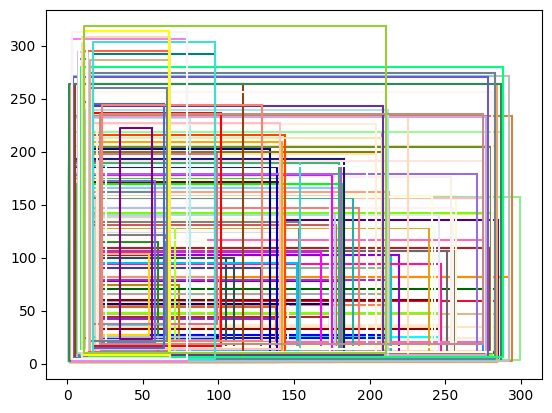

In [163]:
rows = groupbyrow(word_boxes)
print(rows)
import matplotlib.colors as mcolors

def draw_box(box, colour):
    u,l,d,r = box
    xs = [l, r, r, l, l]
    ys = [u, u, d, d, u]
    plt.plot(xs, ys, colour)

colours = list(mcolors.CSS4_COLORS.keys())

for i,row in enumerate(rows):
    for box in row:
        draw_box(box, colours[i])

plt.gca().set_aspect('equal')
plt.show()

In [25]:
def combineLetterIntoWords(boxes):
    half_width = findAverageWidth(boxes) / 2
    words = []

    # group boxes by x-coordinate
    grouped_boxes = {}
    

In [26]:
combineLetterIntoWords(word_boxes)

[[(294, 7, 10, 14),
  (247, 8, 24, 13),
  (103, 54, 27, 7),
  (24, 65, 12, 11),
  (25, 101, 22, 12),
  (25, 138, 16, 11),
  (25, 174, 8, 12),
  (24, 211, 27, 11),
  (25, 247, 10, 12),
  (24, 283, 10, 12)],
 [(343, 7, 12, 13),
  (272, 8, 13, 13),
  (222, 56, 23, 35),
  (162, 58, 10, 21),
  (115, 60, 5, 18),
  (36, 65, 37, 12),
  (34, 174, 10, 12),
  (36, 247, 12, 11),
  (34, 283, 12, 12)],
 [(356, 7, 6, 13),
  (287, 8, 6, 13),
  (172, 58, 19, 22),
  (121, 65, 11, 14),
  (74, 68, 3, 3),
  (74, 74, 3, 2),
  (48, 101, 11, 12),
  (42, 138, 10, 11),
  (44, 174, 11, 12),
  (48, 247, 11, 12),
  (47, 283, 11, 12)],
 [(363, 7, 14, 14),
  (304, 8, 12, 13),
  (245, 64, 15, 15),
  (138, 67, 22, 12),
  (130, 71, 6, 9),
  (117, 92, 25, 23),
  (59, 101, 22, 12),
  (53, 138, 11, 11),
  (56, 174, 20, 12),
  (55, 211, 11, 11),
  (59, 284, 11, 11)],
 [(378, 7, 12, 13),
  (317, 8, 26, 13),
  (260, 66, 21, 13),
  (147, 98, 25, 17),
  (82, 101, 17, 12),
  (65, 141, 3, 3),
  (65, 146, 3, 3),
  (66, 211, 12, 1

In [27]:
def drawBoundingBoxes(image_path, boxes, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Draw bounding boxes around the words
    for word in boxes:
        x, y, w, h = word[0]
        cv2.rectangle(image, (x, y), (word[-1][0] + word[-1][2], word[-1][1] + word[-1][3]), (0, 255, 0), 2)
    
    # Save the image with bounding boxes
    cv2.imwrite(output_path, image)
    print("Image with bounding boxes saved as:", output_path)

drawBoundingBoxes("output1.jpg", combineLetterIntoWords(word_boxes), "output3.jpg")

Image with bounding boxes saved as: output3.jpg


[(247, 8, 24, 13), (272, 8, 13, 13), (294, 7, 10, 14), (287, 8, 6, 13), (304, 8, 12, 13), (317, 8, 26, 13), (343, 7, 12, 13), (356, 7, 6, 13), (363, 7, 14, 14), (378, 7, 12, 13), (103, 54, 27, 7), (24, 65, 12, 11), (36, 65, 37, 12), (115, 60, 5, 18), (162, 58, 10, 21), (172, 58, 19, 22), (74, 68, 3, 3), (121, 65, 11, 14), (222, 56, 23, 35), (138, 67, 22, 12), (74, 74, 3, 2), (130, 71, 6, 9), (340, 53, 17, 25), (245, 64, 15, 15), (260, 66, 21, 13), (286, 67, 8, 15), (295, 67, 11, 11), (325, 65, 14, 13), (314, 67, 8, 11), (308, 68, 5, 10), (366, 64, 16, 14), (25, 101, 22, 12), (117, 92, 25, 23), (232, 81, 1, 1), (48, 101, 11, 12), (59, 101, 22, 12), (82, 101, 17, 12), (306, 79, 2, 3), (313, 79, 4, 3), (147, 98, 25, 17), (341, 79, 4, 3), (100, 105, 3, 3), (363, 79, 2, 5), (198, 99, 37, 17), (100, 110, 3, 3), (236, 102, 17, 13), (292, 98, 4, 17), (303, 98, 4, 17), (314, 99, 20, 16), (90, 128, 11, 23), (25, 138, 16, 11), (42, 138, 10, 11), (264, 116, 1, 5), (53, 138, 11, 11), (65, 141, 3, 3

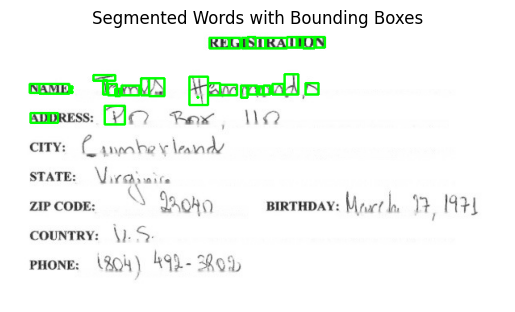

In [155]:
# display the word boxes using plt

def display_word_boxes(image_path, word_boxes):
    # Load the image
    word_boxes.sort(key=lambda x: (x[1]*10+x[0]))
    # lettersByLine = []
    # line = []
    # prevx, prevy, prevw, prevh = word_boxes[0]
    # while len(word_boxes) > 0:
    #     x, y, w, h = word_boxes.pop(0)
    #     if abs(y - prevy) > 10:
    #         lettersByLine.append(line)
    #         line = []
    #     line.append((x, y, w, h))
    #     prevx, prevy, prevw, prevh = x, y, w, h

    # lettersByLine.append(line)
    # word_boxes = lettersByLine
    print(word_boxes)
    image = cv2.imread(image_path)
    
    # Draw bounding boxes around the words
    for box in word_boxes[:35]:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Segmented Words with Bounding Boxes')
    plt.axis('off')
    plt.show()

display_word_boxes("output1.jpg", word_boxes)

[[(292, 98, 4, 17), (294, 7, 10, 14), (295, 67, 11, 11)], [(340, 53, 17, 25), (341, 79, 4, 3), (343, 7, 12, 13), (346, 211, 10, 11)], [(356, 7, 6, 13), (357, 210, 23, 12)], [(363, 7, 14, 14), (363, 79, 2, 5), (366, 64, 16, 14)], [(378, 7, 12, 13), (381, 211, 11, 11)], [(243, 209, 8, 15), (244, 129, 21, 23), (245, 64, 15, 15), (247, 8, 24, 13)], [(270, 278, 5, 4), (271, 283, 3, 3), (271, 292, 2, 3), (272, 8, 13, 13), (274, 283, 4, 14)], [(286, 67, 8, 15), (287, 8, 6, 13)], [(303, 98, 4, 17), (304, 8, 12, 13), (306, 79, 2, 3), (308, 68, 5, 10)], [(313, 79, 4, 3), (314, 67, 8, 11), (314, 99, 20, 16), (317, 8, 26, 13), (318, 211, 10, 11)], [(100, 105, 3, 3), (100, 110, 3, 3), (102, 214, 3, 3), (102, 219, 3, 3), (103, 54, 27, 7), (105, 168, 15, 20), (106, 251, 3, 3), (106, 256, 3, 3)], [(218, 208, 5, 7), (218, 287, 6, 2), (222, 56, 23, 35), (226, 204, 9, 20)], [(158, 182, 3, 6), (162, 58, 10, 21)], [(169, 182, 6, 6), (171, 142, 9, 9), (172, 58, 19, 22)], [(115, 60, 5, 18), (115, 142, 4, 13)

In [134]:
# Instantiate Aspose.OCR API
from asposeocr import AsposeOcr, OcrInput, InputType, AreasType

api = AsposeOcr()
# Add image to the recognition batch
input = OcrInput(InputType.SINGLE_IMAGE)
input.add("output1.jpg")
# Detect words
results = api.detect_rectangles(input, AreasType.WORDS)
for region in results[0].rectangles:
    print(region.top + ", " + region.left + ", " + region.width + ", " + region.height)


TypeError: ['function takes at most 1 argument (2 given)', "function missing required argument 'detect_areas' (pos 3)"]

In [146]:
import aspose.ocr as ocr

aspose_ocr = ocr.AsposeOcr()

ocr_input = ocr.OcrInput("output1.jpg")
# ocr_input.add_image()

recognized_text = aspose_ocr.recognize(ocr_input)

print(recognized_text)

TypeError: ["can't build InputType value from 'str'", "can't build InputType value from 'str'"]

In [148]:
import aspose.ocr as ocr

# Instantiate Aspose.OCR API
api = AsposeOcr()

# Add image to the recognition batch
input = OcrInput(InputType.SINGLE_IMAGE)
input.add("output1.jpg")

# Recognize the image
result = api.recognize(input)

# Print recognition result
print(result[0].recognition_text)
input("Press Enter to continue...")


REGISTRATIO
 ************* Trial Licenses ************* 



TypeError: 'aspose.ocr.OcrInput' object is not callable